# New LSTM inspired by Kaggle 

###### (https://www.kaggle.com/code/anseldsouza/bitcoin-price-prediction-using-lstm/notebook)

### Import modules

In [1]:
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import keras_tuner as kt

2023-03-12 13:51:16.244678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import keras

In [3]:
register_matplotlib_converters()
sns.set(font_scale=1, style="whitegrid")

# Visualize Data

In [4]:
# change path
# btc_data_path = "C:/Users/alexk/Desktop/Uni/TU_Berlin/WS22_23/AUT PRJ Unterlagen/Bot/data/BTC_histData_dt1800.0s_20220825_0629.csv"
btc_data_path = "./../data/BTC_histData_dt1800.0s_20220825_0629.csv"

df = pd.read_csv(btc_data_path)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
list(df.columns)

['date',
 'open',
 'high',
 'low',
 'close',
 'Volume',
 '20ema',
 '12ema',
 '26ema',
 '50ema',
 '200ema',
 'mfi',
 'obv_val',
 'obv_ema',
 'stochRsi13',
 'stochRsi_d',
 'stochRsi_k',
 'rsi14',
 'rsi5',
 'macd',
 'signal',
 'histogram',
 'macd2',
 'signal2',
 'hist2',
 'label']

In [5]:
print(df.head())

                 date     open     high      low    close      Volume  20ema  \
0 2020-01-01 00:00:00  7195.24  7196.25  7175.47  7178.45  331.185522    NaN   
1 2020-01-01 00:30:00  7178.19  7185.44  7175.46  7177.02  180.629379    NaN   
2 2020-01-01 01:00:00  7176.47  7217.00  7175.71  7212.10  355.063574    NaN   
3 2020-01-01 01:30:00  7212.10  7230.00  7204.28  7216.27  527.989029    NaN   
4 2020-01-01 02:00:00  7215.52  7238.88  7211.41  7228.09  309.018157    NaN   

   12ema  26ema  50ema  ...  stochRsi_k  rsi14  rsi5  macd  signal  histogram  \
0    NaN    NaN    NaN  ...         NaN    NaN   NaN   NaN     NaN        NaN   
1    NaN    NaN    NaN  ...         NaN    NaN   NaN   NaN     NaN        NaN   
2    NaN    NaN    NaN  ...         NaN    NaN   NaN   NaN     NaN        NaN   
3    NaN    NaN    NaN  ...         NaN    NaN   NaN   NaN     NaN        NaN   
4    NaN    NaN    NaN  ...         NaN    NaN   NaN   NaN     NaN        NaN   

   macd2  signal2  hist2  label 

### close price variation 

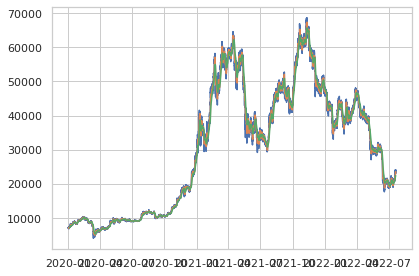

In [6]:
price_date = df['date']
price_close = df['close']
ema50 = df['50ema']
ema200 = df['200ema']

plt.plot(price_date, price_close, linestyle='solid')
plt.plot(price_date, ema50,linestyle='solid')
plt.plot(price_date,ema200, linestyle='solid')
plt.tight_layout()
plt.show()

### volume variation for every 30 minutes

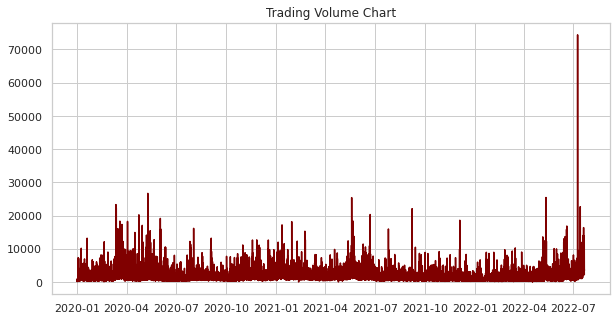

In [7]:
fig = plt.figure(figsize = (10, 5))
plt.plot(df["date"], df["Volume"], color ='maroon')
plt.title("Trading Volume Chart")
plt.show()

In [8]:
df = df.set_index('date')
df['Daily Return'] = df['open'].pct_change(freq='d')

<AxesSubplot:xlabel='date'>

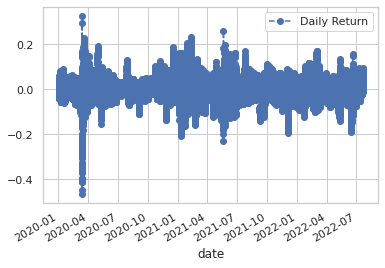

In [9]:
df['Daily Return'].plot(legend=True, linestyle='--', marker='o')

/tmp/ipykernel_10536/3676145627.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Daily Return'].dropna(), bins=100, color='purple')


Text(0, 0.5, 'Daily Return')

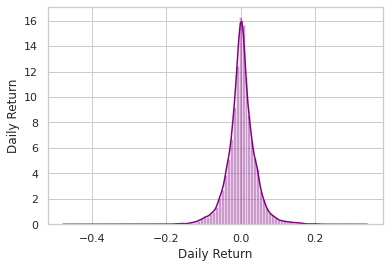

In [10]:
sns.distplot(df['Daily Return'].dropna(), bins=100, color='purple')
plt.ylabel('Daily Return')

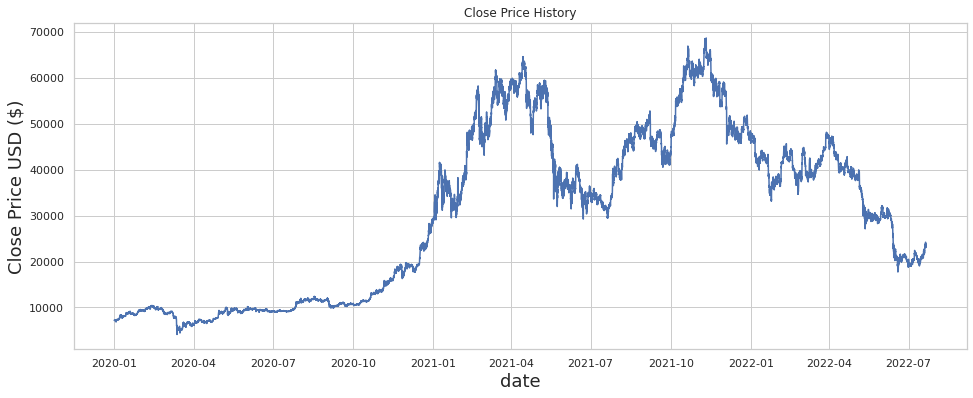

In [11]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['close'])
plt.xlabel('date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [12]:
df_relevant_data = df[['open','close', 'high','low','Volume','rsi14','rsi5','macd','mfi','obv_val']]
df_relevant_data

,open,close,high,low,Volume,rsi14,rsi5,macd,mfi,obv_val
date,,,,,,,,,,
2020-01-01 00:00:00,7195.24,7178.45,7196.25,7175.47,331.185522,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:30:00,7178.19,7177.02,7185.44,7175.46,180.629379,NaN,NaN,NaN,NaN,-180.629379
2020-01-01 01:00:00,7176.47,7212.10,7217.00,7175.71,355.063574,NaN,NaN,NaN,NaN,174.434195
2020-01-01 01:30:00,7212.10,7216.27,7230.00,7204.28,527.989029,NaN,NaN,NaN,NaN,702.423224
2020-01-01 02:00:00,7215.52,7228.09,7238.88,7211.41,309.018157,NaN,NaN,NaN,NaN,1011.441381
...,...,...,...,...,...,...,...,...,...,...
2022-07-20 22:00:00,23607.06,23532.31,23641.78,23438.76,2180.146740,48.329563,50.810461,-46.194335,32.326773,605182.636676
2022-07-20 22:30:00,23532.31,23309.06,23574.10,23304.56,2996.381430,43.371358,38.597147,-62.248233,25.866009,602186.255246
2022-07-20 23:00:00,23309.06,23222.75,23334.71,23111.00,3391.708860,41.594700,34.580271,-81.001821,26.800219,598794.546386


In [13]:
df_relevant_data_rev = df_relevant_data
df_relevant_data_rev = df_relevant_data_rev.fillna(df_relevant_data_rev.mean())


In [14]:
df_relevant_data_rev

,open,close,high,low,Volume,rsi14,rsi5,macd,mfi,obv_val
date,,,,,,,,,,
2020-01-01 00:00:00,7195.24,7178.45,7196.25,7175.47,331.185522,50.917629,50.954609,2.567246,50.599859,304943.431184
2020-01-01 00:30:00,7178.19,7177.02,7185.44,7175.46,180.629379,50.917629,50.954609,2.567246,50.599859,-180.629379
2020-01-01 01:00:00,7176.47,7212.10,7217.00,7175.71,355.063574,50.917629,50.954609,2.567246,50.599859,174.434195
2020-01-01 01:30:00,7212.10,7216.27,7230.00,7204.28,527.989029,50.917629,50.954609,2.567246,50.599859,702.423224
2020-01-01 02:00:00,7215.52,7228.09,7238.88,7211.41,309.018157,50.917629,50.954609,2.567246,50.599859,1011.441381
...,...,...,...,...,...,...,...,...,...,...
2022-07-20 22:00:00,23607.06,23532.31,23641.78,23438.76,2180.146740,48.329563,50.810461,-46.194335,32.326773,605182.636676
2022-07-20 22:30:00,23532.31,23309.06,23574.10,23304.56,2996.381430,43.371358,38.597147,-62.248233,25.866009,602186.255246
2022-07-20 23:00:00,23309.06,23222.75,23334.71,23111.00,3391.708860,41.594700,34.580271,-81.001821,26.800219,598794.546386


In [15]:
look_back = 1
look_ahead = 5

features = ['Volume', 'open','rsi14','macd']

# Define the function to prepare the data for training
def univariate_data(dataset, start_index, end_index, history_size,
                    target_size, single_step=False):
    data, labels = [], []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = np.arange(i-history_size, i)
        # Select the appropriate features from the DataFrame
        data.append(np.reshape(dataset[features].values[indices], (history_size, len(features))))
        if single_step:
            # Select the closing price as the label
            labels.append(dataset['close'].values[i + target_size])
        else:
            labels.append(dataset['close'].values[i:i + target_size])
    return np.array(data), np.array(labels)


In [16]:
trainX, trainY = univariate_data(df_relevant_data_rev, 0, len(df_relevant_data_rev) - look_ahead, look_back, look_ahead)

In [17]:
trainX.shape, trainY.shape

((44659, 1, 4), (44659, 5))

In [18]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(trainX, trainY, test_size=0.2, random_state=69,shuffle=False)

In [19]:
X_test0.shape

(8932, 1, 4)

In [23]:
# define the size of the historical window and the forecast horizon
look_back = 5
look_ahead = 5

# define the scaler objects
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# reshape the data to a 2D array for scaling
X_2d = trainX.reshape(trainX.shape[0], trainX.shape[1]*trainX.shape[2])
Y_2d = trainY.reshape(trainY.shape[0], look_ahead)

# scale the data
scaled_data_x_2d = scaler_x.fit_transform(X_2d)
scaled_data_y_2d = scaler_y.fit_transform(Y_2d)

scaled_data_x = scaled_data_x_2d.reshape(trainX.shape[0], trainX.shape[1], trainX.shape[2])
scaled_data_y = scaled_data_y_2d.reshape(trainY.shape[0], trainY.shape[1])

In [24]:
scaled_data_x_2d.shape, scaled_data_y_2d.shape

((44659, 4), (44659, 5))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data_x, scaled_data_y, test_size=0.20, random_state=42,shuffle=False)
X_train, X_test, y_train, y_test = np.array(X_train),np.array(X_test), np.array(y_train), np.array(y_test)

In [26]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 4))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 4)) # 4 features
X_train.shape

(35727, 1, 4)

In [27]:
X_test.shape

(8932, 1, 4)

In [28]:
y_train = np.reshape(y_train, (y_train.shape[0], 5)) # 5 predictions
y_test = np.reshape(y_test, (y_test.shape[0],5))
y_test.shape

(8932, 5)

In [42]:
def build_lstm():
    """
    Trial summary
    Hyperparameters:
    input_unit: 288
    n_layers: 4
    lstm_0_units: 64
    lstm_1_units: 480
    lstm_2_units: 128
    lstm_3_units: 32
    layer_2_neurons: 448
    Dropout_rate: 0.0
    dense_activation: sigmoid
    """
#     model = Sequential()
    input_layer = keras.layers.Input(shape=(1,4))
    layer = LSTM(288, return_sequences=True)(input_layer)
    layer = LSTM(64,return_sequences=True)(layer)
    layer = LSTM(480,return_sequences=True)(layer)
    layer = LSTM(128,return_sequences=True)(layer) 
    layer = LSTM(32,return_sequences=True)(layer)
    
    
    layer = LSTM(448)(layer)
    layer = Dropout(0.0)(layer)
    layer = Dense(30, activation='sigmoid')(layer)
    out = Dense(look_ahead, activation='sigmoid')(layer)
    model = keras.Model(input_layer, out)
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    
    return model

In [ ]:
def model_builder(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32), return_sequences=True, input_shape= ( X_train.shape[1],X_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(30, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.add(Dense(look_ahead, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    
    return model

In [ ]:
def model_builder_functional(hp):
    input_layer = keras.layers.Input(shape=(1,4))
    layer = LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32), 
                 return_sequences=True)(input_layer)
    for i in range(hp.Int('n_layers', 1, 4)):
        layer = LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True)(layer)
    layer = (LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))(layer)
    layer = Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1))(layer)
    layer =  Dense(30, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu'))(layer)
    output = Dense(look_ahead, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu'))(layer)
    
    model = kears.Model(input_layer, output)
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    
    return model

In [29]:
tuner = kt.RandomSearch(model_builder, objective="mse", max_trials = 4, executions_per_trial =3,directory = "./lstm-aut/")

INFO:tensorflow:Reloading Tuner from ./lstm-aut/untitled_project/tuner0.json


In [50]:
tuner.search(x=X_train, y=y_train, epochs = 10, batch_size =128, validation_data=(X_test, y_test))

INFO:tensorflow:Reloading Tuner from ./lstm-aut/untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [44]:
checkpoint_filepath = './lstm-aut/untitled_project/trial_2/checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [43]:
model = build_lstm()

In [45]:
model.load_weights(checkpoint_filepath)

In [46]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 288)            337536    
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             90368     
                                                                 
 lstm_2 (LSTM)               (None, 1, 480)            1046400   
                                                                 
 lstm_3 (LSTM)               (None, 1, 128)            311808    
                                                                 
 lstm_4 (LSTM)               (None, 1, 32)             20608     
                                                                 
 lstm_5 (LSTM)               (None, 448)               861952

In [48]:
# model.save("./best_models/11_mar_2023/lstm_2.h5")

In [26]:
best_model = tuner.get_best_models(num_models=1)[0]

In [27]:
tuner.results_summary()

Results summary
Results in ./lstm-aut/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
input_unit: 288
n_layers: 4
lstm_0_units: 64
layer_2_neurons: 448
Dropout_rate: 0.0
dense_activation: sigmoid
lstm_1_units: 480
lstm_2_units: 128
lstm_3_units: 32
Score: 3.9302119451652594e-05
Trial summary
Hyperparameters:
input_unit: 192
n_layers: 3
lstm_0_units: 448
layer_2_neurons: 288
Dropout_rate: 0.30000000000000004
dense_activation: sigmoid
lstm_1_units: 32
lstm_2_units: 32
Score: 6.529854969509567e-05
Trial summary
Hyperparameters:
input_unit: 320
n_layers: 1
lstm_0_units: 384
layer_2_neurons: 192
Dropout_rate: 0.4
dense_activation: sigmoid
Score: 0.00013207103863048056
Trial summary
Hyperparameters:
input_unit: 448
n_layers: 1
lstm_0_units: 448
layer_2_neurons: 224
Dropout_rate: 0.0
dense_activation: relu
lstm_1_units: 96
lstm_2_units: 288
lstm_3_units: 256
Score: 0.02039171439112882


# Run this block for predictions. 

In [47]:
# model = keras.models.load_model("./best_models/11_mar_2023/lstm_2.h5")

OSError: No file or directory found at ./best_models/11_mar_2023/lstm_2.h5

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1, 288)            337536    
                                                                 
 lstm_13 (LSTM)              (None, 1, 64)             90368     
                                                                 
 lstm_14 (LSTM)              (None, 1, 480)            1046400   
                                                                 
 lstm_15 (LSTM)              (None, 1, 128)            311808    
                                                                 
 lstm_16 (LSTM)              (None, 1, 32)             20608     
                                                                 
 lstm_17 (LSTM)              (None, 448)               861952    
                                                                 
 dropout_2 (Dropout)         (None, 448)              

In [31]:
# y_pred = best_model.predict(X_test)
y_pred = model.predict(X_test)

#y_pred = y_pred.reshape(-1,5)
y_pred_unscaled = scaler_y.inverse_transform(y_pred)

280/280 [==============================] - 9s 20ms/step


In [34]:
print(X_test.shape, y_pred.shape)

(8932, 1, 4) (8932, 5)


In [40]:
X_test[:1,:,:]

array([[[0.00442426, 0.60878173, 0.67402055, 0.62260386]]])

In [41]:
y_tmp= model.predict(X_test[:2,:,:])
y_tmp.shape

1/1 [==============================] - 0s 47ms/step


(2, 5)

In [39]:
y_tmp

array([[0.60328823, 0.6035574 , 0.6032039 , 0.60294634, 0.6033072 ]],
      dtype=float32)

In [48]:
pred_df = pd.DataFrame(y_pred_unscaled, columns=['t1','t2','t3','t4','t5'])

In [49]:
X_test_unscaled = scaler_x.inverse_transform(X_test[:,0,:])
X_test_unscaled

array([[ 3.29070640e+02,  4.34000200e+04,  6.47570562e+01,
         1.15250363e+02],
       [ 1.05658697e+03,  4.35283300e+04,  6.93726977e+01,
         1.38680096e+02],
       [ 4.50727990e+02,  4.37046600e+04,  5.90049905e+01,
         1.37933588e+02],
       ...,
       [ 1.38251469e+04,  2.36632400e+04,  3.37454481e+01,
        -1.02477650e+01],
       [ 6.74580610e+03,  2.30302800e+04,  4.08529219e+01,
        -4.01985540e+01],
       [ 3.27388163e+03,  2.32623200e+04,  4.31589207e+01,
        -5.67916958e+01]])

In [56]:
X_test_unscaled.shape

(8932, 4)

In [50]:
valid = pd.DataFrame(X_test_unscaled,columns=['Volume', 'open','rsi14','macd'])
valid['predicted_t5'] = pred_df['t5'].shift(-5)
valid 
train = pd.DataFrame(y_train0)

In [51]:
new_index = [i + len(train) for i in range(len(valid))] # offset index by number of training data
valid = valid.set_index(pd.Index(new_index))

In [52]:
concat = pd.concat([train[0],valid[['open','predicted_t5']]])
len(concat)

44659

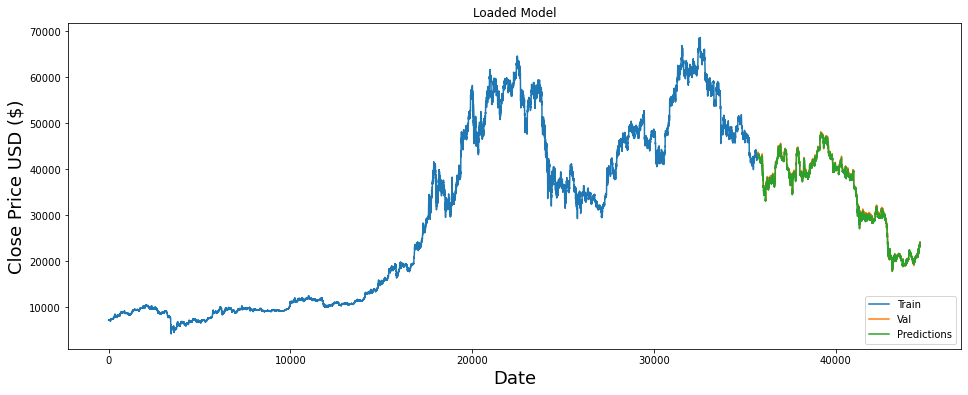

In [53]:
plt.figure(figsize=(16,6))
plt.title('Loaded Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(concat[[0,'open', 'predicted_t5']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

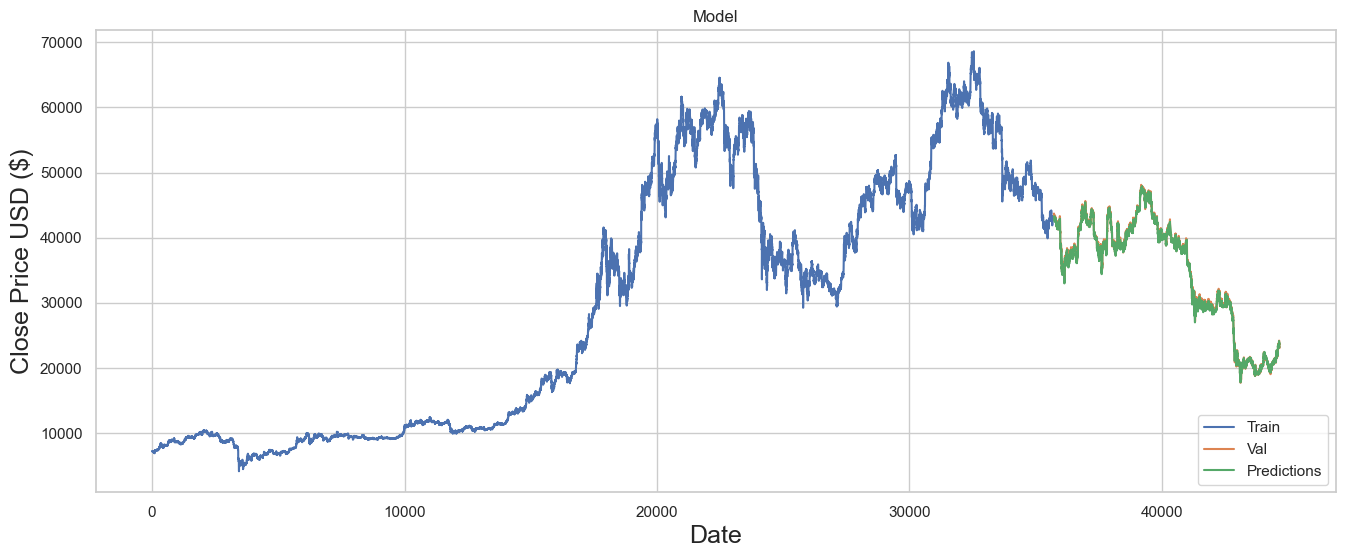

In [87]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(concat[[0,'open', 'predicted_t5']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

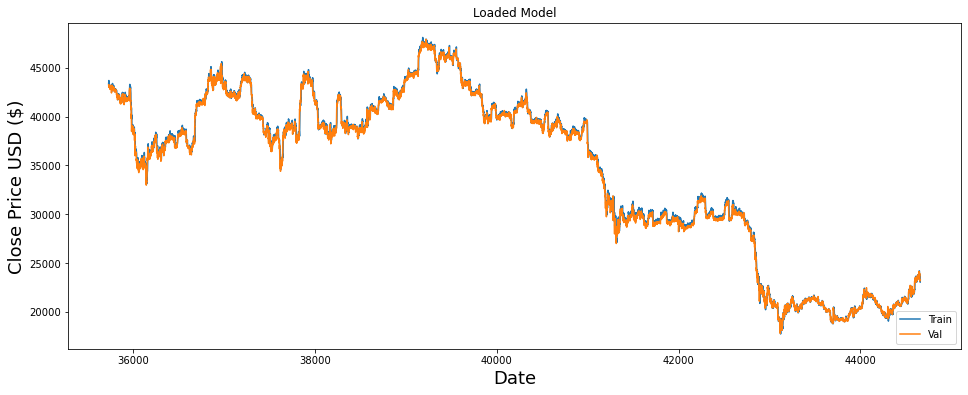

In [54]:
plt.figure(figsize=(16,6))
plt.title('Loaded Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
#plt.plot(y_train0)
plt.plot(valid[['open']])
plt.plot(valid[['predicted_t5']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

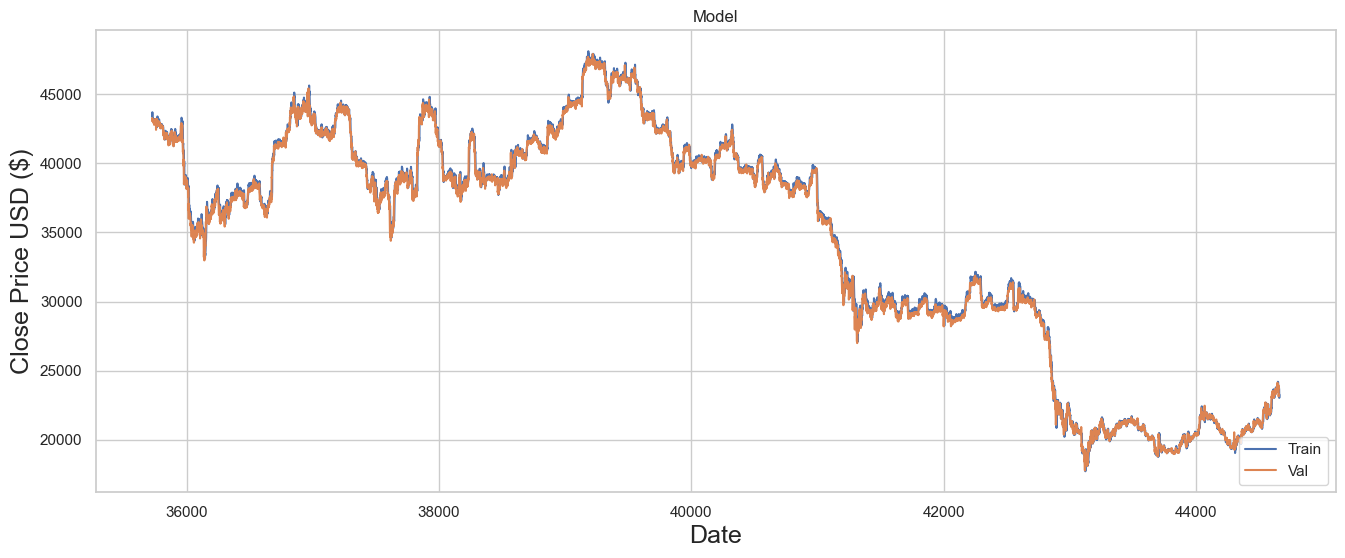

In [88]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
#plt.plot(y_train0)
plt.plot(valid[['open']])
plt.plot(valid[['predicted_t5']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()